# Course Review: Clustering 
  
  
*Nur Andi Setiabudi*  
*August 6, 2021*

---

# Load libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

In [2]:
!pip install plotly==5.1.0

     |████████████████████████████████| 20.6 MB 28.7 MB/s eta 0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 4.14.3
    Uninstalling plotly-4.14.3:
      Successfully uninstalled plotly-4.14.3


# Data Exploration

In [8]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_d6f90f6d8db547338269116fde6f6cd1 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_d6f90f6d8db547338269116fde6f6cd1 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_d6f90f6d8db547338269116fde6f6cd1 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ZmmNpzzpzRHZT8bcIfhb4nX2N6p9bfpGv4dCQJsx9wrz',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_d6f90f6d8db547338269116fde6f6cd1)

body = client_d6f90f6d8db547338269116fde6f6cd1.get_object(Bucket='mentoring7-donotdelete-pr-id5zloivmjzyet',Key='Customers.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
df.shape

(200, 5)

In [10]:
df.describe()

,CustomerID,Age,AnnualIncome,SpendingScore
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


# Data Visualization

In [11]:
plt.style.use('seaborn')

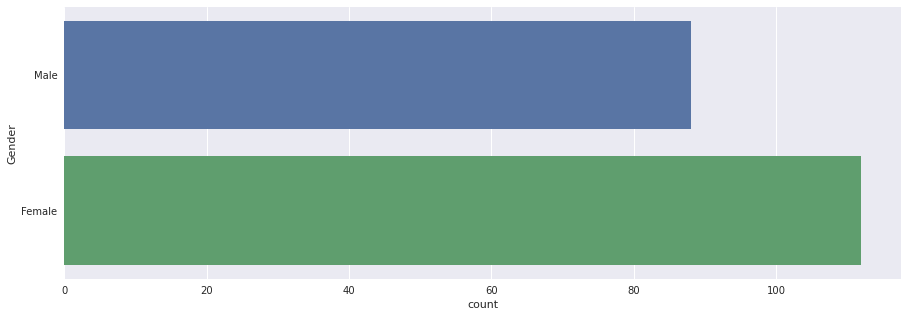

In [12]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df)
plt.show()

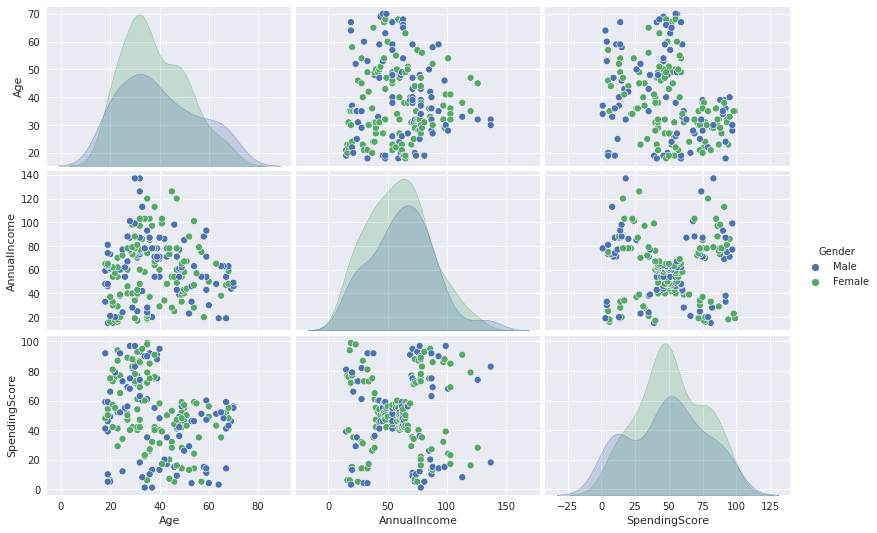

In [13]:
sns.pairplot(df.drop('CustomerID', axis=1), hue='Gender', aspect=1.5)
plt.show()

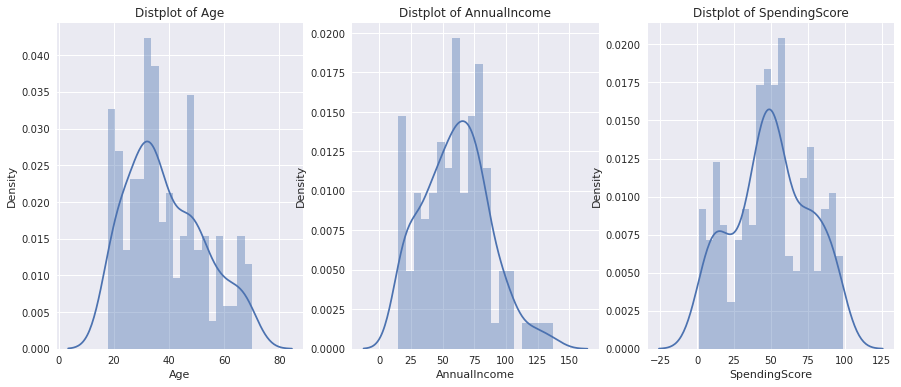

In [14]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'AnnualIncome' , 'SpendingScore']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

# Standardized Variable (Optional but Strongly Recommended)

In [15]:
X = df.drop(['CustomerID', 'Gender'], axis=1)

standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns


# <font color='blue'>K-Means Clustering</font>


# K-Means: with 2 variables with speculated k

Lets segment the data based on 2 variables: Annual Income and Spending Score (scaled spending amount between 0-100)

In [16]:
X_is = X_std[['AnnualIncome' , 'SpendingScore']].values

K-Means requires pre-defined number of clusters, eg. 3

In [17]:
k = 3
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_is)

centroids = k_means.cluster_centers_

Plot the segments

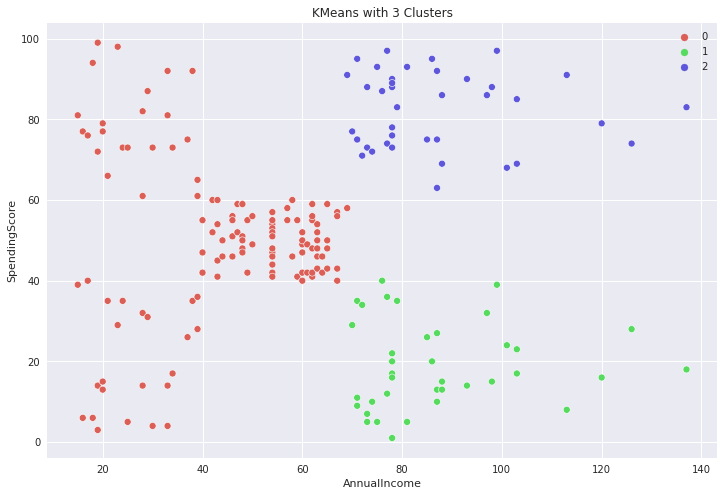

In [18]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['AnnualIncome'], X['SpendingScore'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

`k_means.cluster_centers_` outputs the centroid based on standardized-data. We can easily calculate the centroid using original data

In [19]:
centroids = X[['AnnualIncome','SpendingScore']].groupby(Segment, as_index=False).mean()
centroids

,AnnualIncome,SpendingScore
0,44.154472,49.829268
1,87.000000,18.631579
2,86.538462,82.128205


# K-Means (2): 2 Variables with Elbow Method and Silhouette to Determine k

There are several methods to determine number of clusters for K-Means, eg. Elbow method using inertia or Silhouette score. 

In [20]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

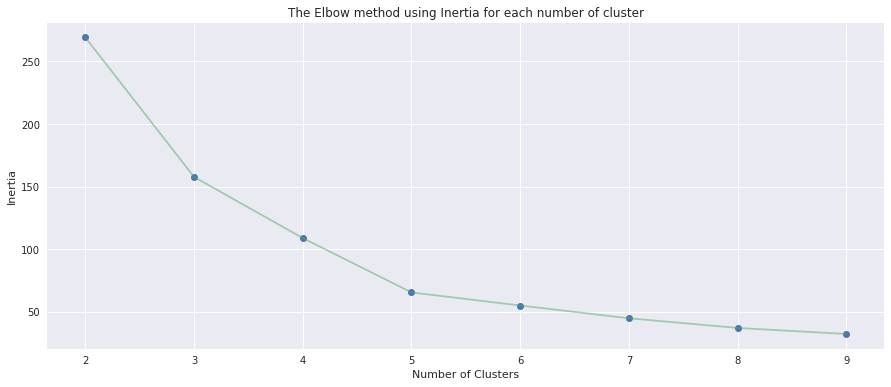

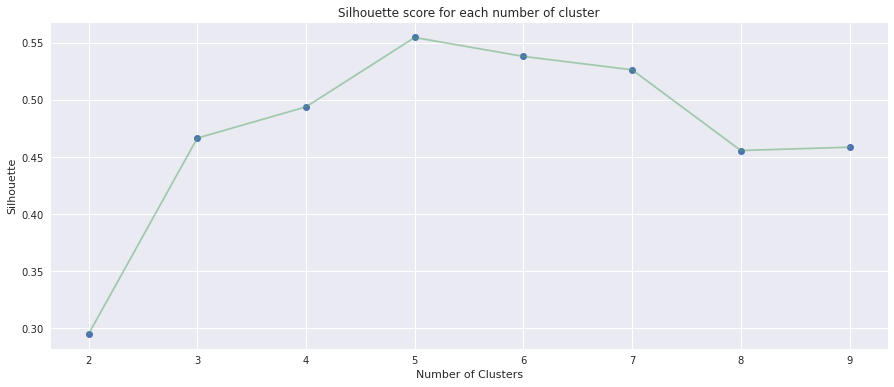

In [21]:
inertia, silhouette = k_means_inertia_silhouette(X = X_is)

Choose the k for which inertia becomes first starts to diminish. In the plot, this is visible as an elbow. If Silhouette score is used, choose the k with the highest score

In [22]:
k = 5
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_is)

KMeans(n_clusters=5, random_state=123)

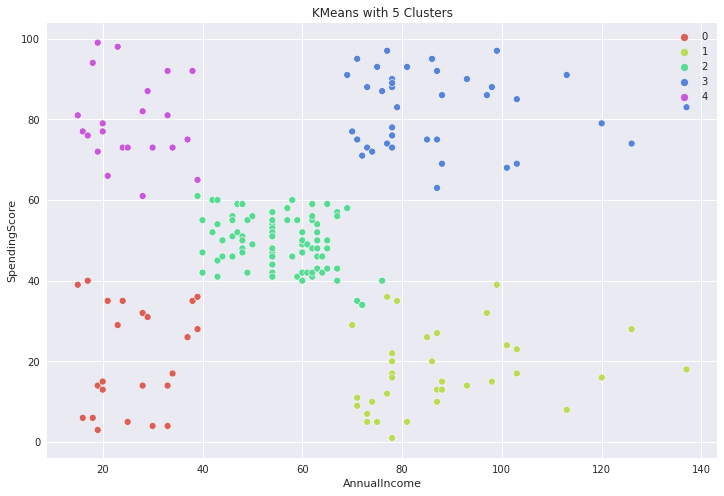

In [23]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['AnnualIncome'], X['SpendingScore'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [24]:
centroids = X[['AnnualIncome','SpendingScore']].groupby(Segment, as_index=False).mean()
centroids

,AnnualIncome,SpendingScore
0,26.304348,20.913043
1,88.200000,17.114286
2,55.296296,49.518519
3,86.538462,82.128205
4,25.727273,79.363636


# K-Means (3): 3 Variables with Elbow Method and Silhouette to Determine k

Lets try using 3 variables

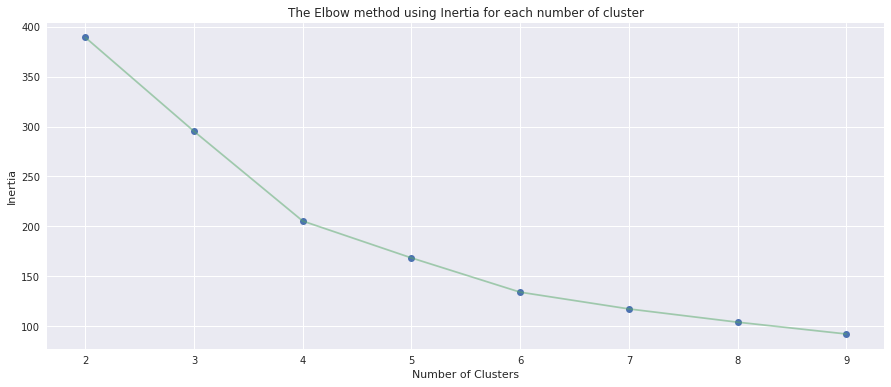

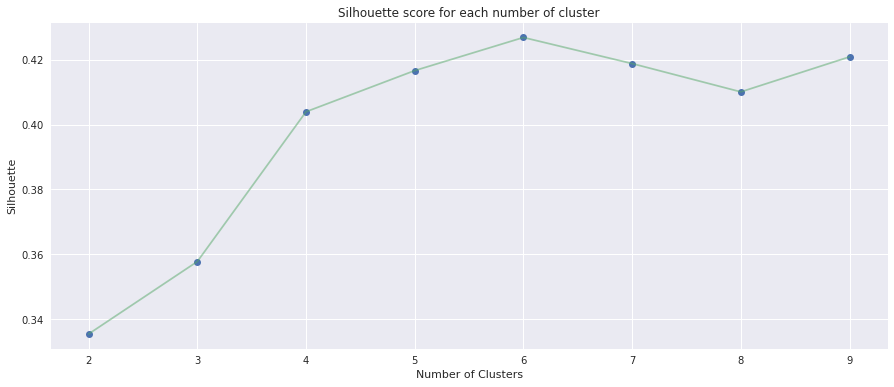

In [25]:
inertia, silhouette = k_means_inertia_silhouette(X_std, k_max = 10, init = 'k-means++')

In [26]:
k = 6
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_std)

KMeans(n_clusters=6, random_state=123)

In [27]:
Segment = k_means.labels_
X.groupby(Segment, as_index=False).mean()

,Age,AnnualIncome,SpendingScore
0,41.264706,88.500000,16.764706
1,56.333333,54.266667,49.066667
2,32.692308,86.538462,82.128205
3,25.000000,25.260870,77.608696
4,45.523810,26.285714,19.380952
5,27.000000,56.657895,49.131579


Although you can use static 3d-scatter plot to visualize 3 dimension data, I recommend to use interactive plot using plotly. Note that plotly require javascript, it might not work in github page or other static document. If that is the case, import plotly visualisation to static image using `fig.show('svg')`.

In [28]:
X['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='Age', y='AnnualIncome', z='SpendingScore', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

# <font color='blue'>Hierarchical Clustering: Agglomerative</font>

In contrast to K-Means, hierarchical clustering: agglomerative does not require pre-defined number of segment. We can easily choose the number of segment by creating and inspecting dendrogram. 

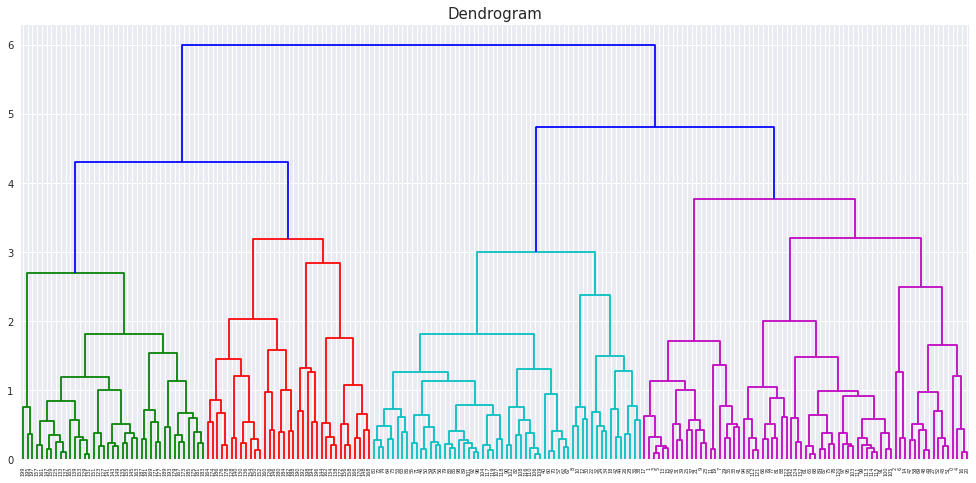

In [29]:
plt.figure(figsize = (17, 8))

dendo = dendrogram(linkage(X_std, method = 'complete'))
plt.title('Dendrogram', fontsize = 15)
plt.show()

Once we had decided number of segment based on dendrogram, we can create clusters.

In [30]:
agglo_cluster = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'complete')
Segment = agglo_cluster.fit_predict(X_std)
Segment

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3,
       0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3,
       1, 3])

Always recalculate cluster centers using original data to profile distinctive characteristics of each segment. 

In [31]:
centroids = X.groupby(Segment, as_index=False).mean()
centroids

,Age,AnnualIncome,SpendingScore
0,27.275362,42.782609,56.376812
1,41.685714,88.228571,17.285714
2,55.333333,47.315789,41.087719
3,32.692308,86.538462,82.128205


Visualise the segments

In [32]:
X['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='Age', y='AnnualIncome', z='SpendingScore', color='Segment',
                   opacity = 0.8, height=800)
fig.show()

# <font color='blue'>Density-based Clustering: DBSCAN</font>

Density-based clustering, eg. DBSCAN, work well to identify the outliers. Since previous dataset is not large enough to demonstrate it, we will use simulated data to exercise DBSCAN. 

In [33]:
centers = [[1, 1], [-1, -1], [1, -1]]  
S, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=0.4, 
                            random_state=0) 

S = StandardScaler().fit_transform(S)

DBSCAN requires two arguments: `eps` or radius (the maximum distance between two samples for one to be considered as in the neighborhood of the other) and `min_samples` (the minimum number of data points we want in a neighborhood to define a cluster).

In [34]:
db = DBSCAN(eps=0.3, min_samples=20).fit(S)

Always try different `eps` and `min_samples` until we find satistactory result

In [35]:
# Number of clusters in labels, ignoring noise if present.
# the label -1 is considered as noise by the DBSCAN algorithm

labels = db.labels_ 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 39


In [36]:
homogeneity =homogeneity_score(labels_true, labels)
print("Homogeneity: %0.3f" % homogeneity)

Homogeneity: 0.914


Lets visualise

In [37]:
# Create an array of booleans using the labels from db.

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

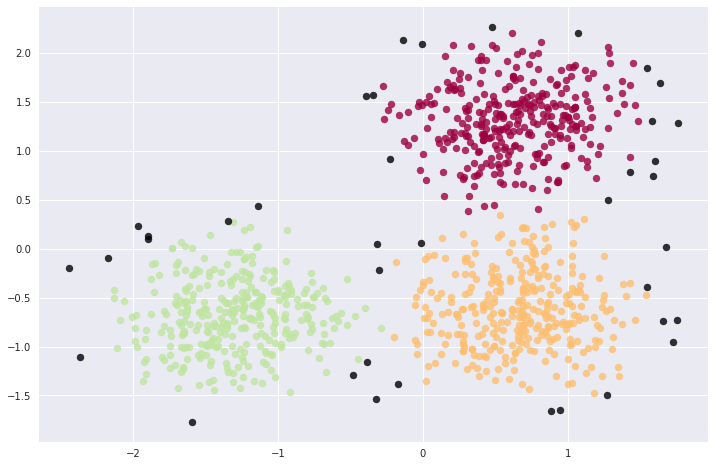

In [38]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))] 

plt.figure(figsize=(12, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = S[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.8)

    # Plot the outliers
    xy = S[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.8)

### Lets compare to K-Means

Compare to K-means (and/or other algorithms) to see if DBSCAN works better

In [39]:
k = 3
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(S)

KMeans(n_clusters=3, random_state=123)

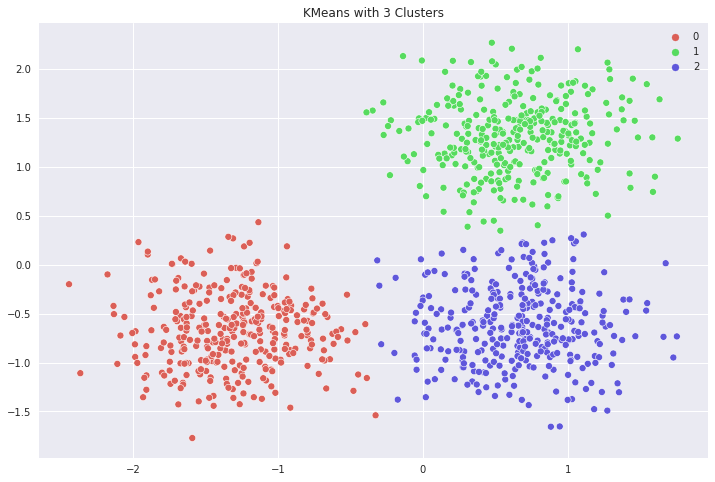

In [40]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(S[:,0], S[:,1], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

----

# <font color='blue'>Task</font>

A simple yet powerful marketing technique is an analysis utilizing _recency_ (how recent was the customer's last purchase), _frequency_ (how often did the customer make a purchase in a given period) and _monetary_ (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns. 

As data scientist you are asked to segment the customers using transaction data and profile them based-on their characteristics (recency, frequency, monetary). After you find the segments, name them using understandable words so marketing team can easily create campaign strategies.

**Data:**
`../data/transactions.csv`

**Hints:** 
For each customer id, generate time difference between their last transaction and today. You should also calculate number of transaction and total amount of spending. You are allowed to use SQL.

**Output:**
Push the *executed* notebook into your github repo and submit the URL to ketua kelas no later than August 21, 2021. Note that notebook must contain explanatory analysis and clustering as well as story about your findings.

**Goodluck!**



---

Data source (with a minor modification): [this](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python?select=Mall_Customers.csv) and [this](https://www.kaggle.com/regivm/retailtransactiondata?select=Retail_Data_Transactions.csv)